<a href="https://colab.research.google.com/github/djsg2021utec/TESIS_MAESTRIA/blob/main/ViVIT_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install torch torchvision -U

In [19]:
%%capture
from tqdm import tqdm
import time
import os
from base64 import b64encode
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import HTML
from base64 import b64encode
from matplotlib import pyplot as plt
import glob
from random import shuffle
import tensorflow as tf
import torch
import shutil
import sys
from torch.utils.data import DataLoader, TensorDataset, random_split

### Extraer los videos

In [1]:
# Enlace del repositorio donde está alojandos los datos
# https://github.com/mchengny/RWF2000-Video-Database-for-Violence-Detection


#%pip install gdown (Descomentar si requiere instalar)

# ********************************************************************
# Descargando los fragmentos del archivo ZIP de la data RWF-2000.zip
# ********************************************************************
download_links = [
    "https://drive.google.com/uc?id=1nQ9IR3cGc4NEDOXhPQ89id8je8Uj2VUc",
    "https://drive.google.com/uc?id=1w9G_Z7gkXZzK4DImdI8wanyjs22fQARO",
    "https://drive.google.com/uc?id=15LhjavoUsLS01CPkc3qav0rJxBc9d4nl"
]

for link in tqdm(download_links, desc="Descargando fragmentos"):
    !gdown {link}
# ********************************************************************
# Juntando los fragmentos del archivo ZIP de la data RWF-2000.zip
# ********************************************************************
!cat RWF-2000.zip.001 RWF-2000.zip.002 RWF-2000.zip.003 > RWF-2000.zip

# Eliminando los fragmentos
for fragment in tqdm(["RWF-2000.zip.001", "RWF-2000.zip.002", "RWF-2000.zip.003"], desc="Eliminando fragmentos"):
    !rm /content/{fragment}

# Descomprimiendo los archivos en el directorio RWF-2000
!unzip "/content/RWF-2000.zip" -d "/content/"

# Eliminando RWF-2000.zip
!rm /content/RWF-2000.zip

# Asegurar que la memoria RAM se liberó
import gc
gc.collect()

time.sleep(10)

In [3]:
# ******************************************************************
# Se crea un dataframe para manejar fácilmente los datos de RWF-2000
# ******************************************************************
carpeta = 'RWF-2000'
lista_carpetas_avi = [
    {'ruta': f'/content/{carpeta}/train/Fight', 'data': 'train', 'etiqueta':'Fight'},
    {'ruta': f'/content/{carpeta}/train/NonFight', 'data': 'train', 'etiqueta':'NonFight'},
    {'ruta': f'/content/{carpeta}/val/Fight', 'data': 'val', 'etiqueta':'Fight'},
    {'ruta': f'/content/{carpeta}/val/NonFight', 'data': 'val', 'etiqueta':'NonFight'}
]
lista_archivos_avi = []
for carpeta in lista_carpetas_avi:
  ruta_carpeta=carpeta['ruta']
  tipo_data =carpeta['data']
  etiqueta_data =carpeta['etiqueta']
  for filename in os.listdir(ruta_carpeta):
      if filename.endswith(".avi"):
        registro_archivo = {'ruta': f'{ruta_carpeta}/{filename}', 'data': f'{tipo_data}', 'etiqueta':f'{etiqueta_data}'}
        lista_archivos_avi.append(registro_archivo)


In [ ]:
videos_RWF2000_df = pd.DataFrame(lista_archivos_avi)
videos_RWF2000_df.describe()


In [29]:

# **********************************************************************
# Se toma una muestra con una fracción de los datos del dataframe
# **********************************************************************

# Función para obtener un subconjunto aleatorio del DataFrame
def grupo_de_muestras(group, frac=0.1):
    return group.sample(frac=frac)

# Dividir el DataFrame según las variables 'etapa' y 'etiqueta' y aplicar la función grupo_de_muestras
muestra_RWF2000_df = videos_RWF2000_df.groupby(['data', 'etiqueta']).apply(grupo_de_muestras).reset_index(drop=True)
# Se elimina una variable que tiene muchas variables
del videos_RWF2000_df

muestra_RWF2000_df.describe()

,ruta,data,etiqueta
count,200,200,200
unique,200,2,2
top,/content/RWF-2000/train/Fight/Jq8neqBlL2Y_2.avi,train,Fight
freq,1,160,100


### No es necesario hacer la conversión a .mp4 porque se puede usar directamente el archivo .avi para construir los tensores

In [ ]:
# Se crea una función para que convierta un .avi a .mp4 en la misma carpeta con la condición que existan frames

def volver_crear_mp4(ruta):
  path = ruta
  if os.path.exists(ruta):
    print("Se elimina el archivo: ",path)
    os.remove(ruta)
    time.sleep(4)
  root = os.path.dirname(path)
  nombre=path.split('/')[-1:][0].split('.')[0]
  ruta_archivo_avi=f'{root}/{nombre}.avi'
  ruta_archivo_mp4=f'{root}/{nombre}'

  os.popen("ffmpeg -i '{input}' -ac 2 -b:v 2000k -c:a aac -c:v libx264 -b:a 160k -vprofile high -bf 0 -strict experimental -f mp4 '{output}.mp4'".format(input=ruta_archivo_avi, output=ruta_archivo_mp4))
  if os.path.exists(f'{ruta_archivo_mp4}.mp4'):
    print("Se vuelve a crear el archivo: ",path)
    time.sleep(10)

In [16]:

def obtener_tensor(video_paths):
  videos = []
  for video_path in video_paths:
    # Abrir el video
    cap = cv2.VideoCapture(video_path)

    # Obtener las características del video
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = num_frames / fps

    # Definir la resolución y el número de canales deseados
    target_resolution = (224, 224)
    target_channels = 3

    # Inicializar una lista para almacenar los frames redimensionados
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Número de canales deseado
        if frame.shape[-1] != target_channels:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convertir a RGB si es necesario

        # Redimensionar el frame a la resolución deseada usando tf.image.resize
        frame = tf.image.resize(frame, target_resolution)

        # Convertir el frame a tensor y agregarlo a la lista
        frame_tensor = tf.convert_to_tensor(frame, dtype=tf.float32) / 255.0
        frames.append(frame_tensor)

    # Apilar los frames en un tensor 4D (frames, alto, ancho, canales)
    video_tensor = tf.stack(frames, axis=0)
    video_tensor = tf.transpose(video_tensor, [3, 0, 1, 2])
    video_tensor = torch.tensor(video_tensor.numpy())
    videos.append(video_tensor)
    # Liberar los recursos
    cap.release()

  tensor_torch = torch.stack(videos, dim=0)
  # Imprimir las dimensiones del tensor resultante
  print("Dimensiones del tensor resultante:", tensor_torch.shape)
  return tensor_torch

def obtener_labels(video_labels):
  # Crear un diccionario de mapeo de etiquetas a valores binarios (1 y 0)
  label_map = {'Fight': 1, 'NonFight': 0}

  # Convertir las etiquetas a valores binarios usando el mapeo
  binary_labels = [label_map[label] for label in video_labels]

  # Crear un tensor de PyTorch a partir de la lista de valores binarios
  tensor_labels = torch.tensor(binary_labels, dtype=torch.float32).to(torch.long)

  # Imprimir las dimensiones del tensor resultante
  print("Dimensiones del tensor resultante:", tensor_labels.shape)
  return tensor_labels

In [38]:
train_video_paths = list(muestra_RWF2000_df[muestra_RWF2000_df['data']=='train']['ruta'])
train_video_labels = list(muestra_RWF2000_df[muestra_RWF2000_df['data']=='train']['etiqueta'])
# tensor_data = obtener_tensor()
train_videos = obtener_tensor(train_video_paths)
train_labels = obtener_labels(train_video_labels)

Dimensiones del tensor resultante: torch.Size([160, 3, 150, 224, 224])
Dimensiones del tensor resultante: torch.Size([160])


In [39]:
test_video_paths = list(muestra_RWF2000_df[muestra_RWF2000_df['data']=='val']['ruta'])
test_video_labels = list(muestra_RWF2000_df[muestra_RWF2000_df['data']=='val']['etiqueta'])
# tensor_data = obtener_tensor()
test_videos = obtener_tensor(test_video_paths)
test_labels = obtener_labels(test_video_labels)

Dimensiones del tensor resultante: torch.Size([40, 3, 150, 224, 224])
Dimensiones del tensor resultante: torch.Size([40])


In [40]:
train_data=TensorDataset(train_videos, train_labels)
test_data=TensorDataset(test_videos, test_labels)

# Entrenar el modelo

In [34]:
%pip install einops
from torch import nn, einsum
import torch
from einops.layers.torch import Rearrange
from einops import rearrange, repeat


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FSAttention(nn.Module):
    """Factorized Self-Attention"""

    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class FDAttention(nn.Module):
    """Factorized Dot-product Attention"""

    def __init__(self, dim, nt, nh, nw, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.nt = nt
        self.nh = nh
        self.nw = nw

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, d, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        qs, qt = q.chunk(2, dim=1)
        ks, kt = k.chunk(2, dim=1)
        vs, vt = v.chunk(2, dim=1)

        # Attention over spatial dimension
        qs = qs.view(b, h // 2, self.nt, self.nh * self.nw, -1)
        ks, vs = ks.view(b, h // 2, self.nt, self.nh * self.nw, -1), vs.view(b, h // 2, self.nt, self.nh * self.nw, -1)
        spatial_dots = einsum('b h t i d, b h t j d -> b h t i j', qs, ks) * self.scale
        sp_attn = self.attend(spatial_dots)
        spatial_out = einsum('b h t i j, b h t j d -> b h t i d', sp_attn, vs)

        # Attention over temporal dimension
        qt = qt.view(b, h // 2, self.nh * self.nw, self.nt, -1)
        kt, vt = kt.view(b, h // 2, self.nh * self.nw, self.nt, -1), vt.view(b, h // 2, self.nh * self.nw, self.nt, -1)
        temporal_dots = einsum('b h s i d, b h s j d -> b h s i j', qt, kt) * self.scale
        temporal_attn = self.attend(temporal_dots)
        temporal_out = einsum('b h s i j, b h s j d -> b h s i d', temporal_attn, vt)

        # return self.to_out(out)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class FSATransformerEncoder(nn.Module):
    """Factorized Self-Attention Transformer Encoder"""

    def __init__(self, dim, depth, heads, dim_head, mlp_dim, nt, nh, nw, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.nt = nt
        self.nh = nh
        self.nw = nw

        for _ in range(depth):
            self.layers.append(nn.ModuleList(
                [PreNorm(dim, FSAttention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                 PreNorm(dim, FSAttention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                 PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
                 ]))

    def forward(self, x):

        b = x.shape[0]
        x = torch.flatten(x, start_dim=0, end_dim=1)  # extract spatial tokens from x

        for sp_attn, temp_attn, ff in self.layers:
            sp_attn_x = sp_attn(x) + x  # Spatial attention

            # Reshape tensors for temporal attention
            sp_attn_x = sp_attn_x.chunk(b, dim=0)
            sp_attn_x = [temp[None] for temp in sp_attn_x]
            sp_attn_x = torch.cat(sp_attn_x, dim=0).transpose(1, 2)
            sp_attn_x = torch.flatten(sp_attn_x, start_dim=0, end_dim=1)

            temp_attn_x = temp_attn(sp_attn_x) + sp_attn_x  # Temporal attention

            x = ff(temp_attn_x) + temp_attn_x  # MLP

            # Again reshape tensor for spatial attention
            x = x.chunk(b, dim=0)
            x = [temp[None] for temp in x]
            x = torch.cat(x, dim=0).transpose(1, 2)
            x = torch.flatten(x, start_dim=0, end_dim=1)

        # Reshape vector to [b, nt*nh*nw, dim]
        x = x.chunk(b, dim=0)
        x = [temp[None] for temp in x]
        x = torch.cat(x, dim=0)
        x = torch.flatten(x, start_dim=1, end_dim=2)
        return x


class FDATransformerEncoder(nn.Module):
    """Factorized Dot-product Attention Transformer Encoder"""

    def __init__(self, dim, depth, heads, dim_head, mlp_dim, nt, nh, nw, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.nt = nt
        self.nh = nh
        self.nw = nw

        for _ in range(depth):
            self.layers.append(
                PreNorm(dim, FDAttention(dim, nt, nh, nw, heads=heads, dim_head=dim_head, dropout=dropout)))

    def forward(self, x):
        for attn in self.layers:
            x = attn(x) + x

        return x


class ViViTBackbone(nn.Module):
    """ Model-3 backbone of ViViT """

    def __init__(self, t, h, w, patch_t, patch_h, patch_w, num_classes, dim, depth, heads, mlp_dim, dim_head=3,
                 channels=3, mode='tubelet', device='cuda', emb_dropout=0., dropout=0., model=3):
        super().__init__()

        assert t % patch_t == 0 and h % patch_h == 0 and w % patch_w == 0, "Video dimensions should be divisible by " \
                                                                           "tubelet size "

        self.T = t
        self.H = h
        self.W = w
        self.channels = channels
        self.t = patch_t
        self.h = patch_h
        self.w = patch_w
        self.mode = mode
        self.device = device

        self.nt = self.T // self.t
        self.nh = self.H // self.h
        self.nw = self.W // self.w

        tubelet_dim = self.t * self.h * self.w * channels

        self.to_tubelet_embedding = nn.Sequential(
            Rearrange('b c (t pt) (h ph) (w pw) -> b t (h w) (pt ph pw c)', pt=self.t, ph=self.h, pw=self.w),
            nn.Linear(tubelet_dim, dim)
        )

        # repeat same spatial position encoding temporally
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, self.nh * self.nw, dim)).repeat(1, self.nt, 1, 1)

        self.dropout = nn.Dropout(emb_dropout)

        if model == 3:
            self.transformer = FSATransformerEncoder(dim, depth, heads, dim_head, mlp_dim,
                                                     self.nt, self.nh, self.nw, dropout)
        elif model == 4:
            assert heads % 2 == 0, "Number of heads should be even"
            self.transformer = FDATransformerEncoder(dim, depth, heads, dim_head, mlp_dim,
                                                     self.nt, self.nh, self.nw, dropout)

        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        """ x is a video: (b, C, T, H, W) """

        tokens = self.to_tubelet_embedding(x)

        tokens += self.pos_embedding.to(device)
        tokens = self.dropout(tokens)

        x = self.transformer(tokens)
        x = x.mean(dim=1)

        x = self.to_latent(x)
        return self.mlp_head(x)


# if __name__ == '__main__':
#     device = torch.device('cuda')
#     x = torch.rand(32, 3, 32, 64, 64).to(device)

#     vivit = ViViTBackbone(32, 64, 64, 8, 4, 4, 10, 512, 6, 10, 8, model=3).to(device)
#     out = vivit(x)
#     print(out)


In [43]:
import torch
torch.cuda.empty_cache()
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split

# Configuración del modelo y del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

v = ViViTBackbone(
    t=150,
    h=224,
    w=224,
    patch_t=30,
    patch_h=28,
    patch_w=28,
    num_classes=2,  # Solo hay 2 clases: violencia y no violencia
    dim=224,
    depth=6,
    heads=10,
    mlp_dim=5,
    model=3
).to(device)


# Dividir en entrenamiento y prueba
# train_data=TensorDataset(train_videos, train_labels)
# test_data=TensorDataset(test_videos, test_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Función de pérdida y optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(v.parameters(), lr=0.01, weight_decay=0.0001)

# Entrenamiento
loss_values = []
num_epochs = 100
for epoch in range(num_epochs):
    v.train()
    avg_loss = 0
    num_batches = 0
    for videos_batch, labels_batch in train_loader:
        videos_batch, labels_batch = videos_batch.to(device), labels_batch.to(device)

        # Propagación hacia adelante
        predictions = v(videos_batch)
        loss = criterion(predictions, labels_batch)

        # Propagación hacia atrás y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        num_batches += 1
    avg_loss /= num_batches
    loss_values.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluación
v.eval()
correct = 0
total = 0
with torch.no_grad():
    for videos_batch, labels_batch in test_loader:
        videos_batch, labels_batch = videos_batch.to(device), labels_batch.to(device)
        predictions = v(videos_batch)
        _, predicted = torch.max(predictions.data, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

print(f"Accuracy of the model on the test videos: {100 * correct / total}%")


Epoch [1/100], Loss: 1.1343
Epoch [2/100], Loss: 0.7603
Epoch [3/100], Loss: 0.9734
Epoch [4/100], Loss: 0.6929
Epoch [5/100], Loss: 0.8139
Epoch [6/100], Loss: 0.6735
Epoch [7/100], Loss: 0.6921
Epoch [8/100], Loss: 0.7046
Epoch [9/100], Loss: 0.6851
Epoch [10/100], Loss: 0.6920
Epoch [11/100], Loss: 0.6764
Epoch [12/100], Loss: 0.7330
Epoch [13/100], Loss: 0.6714
Epoch [14/100], Loss: 0.6705
Epoch [15/100], Loss: 0.6819
Epoch [16/100], Loss: 0.6708
Epoch [17/100], Loss: 0.6800
Epoch [18/100], Loss: 0.6588
Epoch [19/100], Loss: 0.6382
Epoch [20/100], Loss: 0.6694
Epoch [21/100], Loss: 0.6319
Epoch [22/100], Loss: 0.6029
Epoch [23/100], Loss: 0.6457
Epoch [24/100], Loss: 0.6664
Epoch [25/100], Loss: 0.6109
Epoch [26/100], Loss: 0.6202
Epoch [27/100], Loss: 0.6375
Epoch [28/100], Loss: 0.6040
Epoch [29/100], Loss: 0.6556
Epoch [30/100], Loss: 0.6247
Epoch [31/100], Loss: 0.6071
Epoch [32/100], Loss: 0.5607
Epoch [33/100], Loss: 0.6053
Epoch [34/100], Loss: 0.5787
Epoch [35/100], Loss: 0

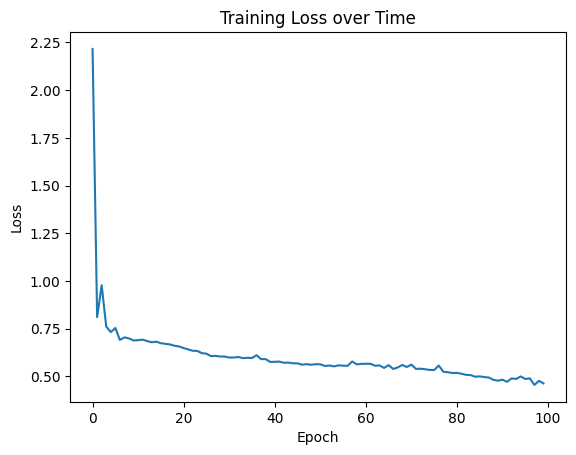

In [44]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.show()

In [ ]:
videos.shape

torch.Size([120, 3, 32, 64, 64])

In [ ]:
labels

['Fight',
 'Fight',
 'Fight',
 'Fight',
 'Fight',
 'Fight',
 'Fight',
 'Fight',
 'NonFight',
 'NonFight',
 'NonFight',
 'NonFight',
 'NonFight',
 'NonFight',
 'NonFight',
 'NonFight',
 'Fight',
 'Fight',
 'NonFight',
 'NonFight']

In [ ]:
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out


class ReAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.reattn_weights = nn.Parameter(torch.randn(heads, heads))

        self.reattn_norm = nn.Sequential(
            Rearrange('b h i j -> b i j h'),
            nn.LayerNorm(heads),
            Rearrange('b i j h -> b h i j')
        )

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        # attention

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = dots.softmax(dim=-1)

        # re-attention

        attn = einsum('b h i j, h g -> b g i j', attn, self.reattn_weights)
        attn = self.reattn_norm(attn)

        # aggregate and out

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class LeFF(nn.Module):

    def __init__(self, dim = 192, scale = 4, depth_kernel = 3):
        super().__init__()

        scale_dim = dim*scale
        self.up_proj = nn.Sequential(nn.Linear(dim, scale_dim),
                                    Rearrange('b n c -> b c n'),
                                    nn.BatchNorm1d(scale_dim),
                                    nn.GELU(),
                                    Rearrange('b c (h w) -> b c h w', h=14, w=14)
                                    )

        self.depth_conv =  nn.Sequential(nn.Conv2d(scale_dim, scale_dim, kernel_size=depth_kernel, padding=1, groups=scale_dim, bias=False),
                          nn.BatchNorm2d(scale_dim),
                          nn.GELU(),
                          Rearrange('b c h w -> b (h w) c', h=14, w=14)
                          )

        self.down_proj = nn.Sequential(nn.Linear(scale_dim, dim),
                                    Rearrange('b n c -> b c n'),
                                    nn.BatchNorm1d(dim),
                                    nn.GELU(),
                                    Rearrange('b c n -> b n c')
                                    )

    def forward(self, x):
        x = self.up_proj(x)
        x = self.depth_conv(x)
        x = self.down_proj(x)
        return x


class LCAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        q = q[:, :, -1, :].unsqueeze(2) # Only Lth element use as query

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out


In [ ]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)



class ViViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_frames, dim = 192, depth = 4, heads = 3, pool = 'cls', in_channels = 3, dim_head = 64, dropout = 0.,
                 emb_dropout = 0., scale_dim = 4, ):
        super().__init__()

        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'


        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size ** 2
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_frames, num_patches + 1, dim))
        self.space_token = nn.Parameter(torch.randn(1, 1, dim))
        self.space_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.temporal_token = nn.Parameter(torch.randn(1, 1, dim))
        self.temporal_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.dropout = nn.Dropout(emb_dropout)
        self.pool = pool

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.to_patch_embedding(x)
        b, t, n, _ = x.shape

        cls_space_tokens = repeat(self.space_token, '() n d -> b t n d', b = b, t=t)
        x = torch.cat((cls_space_tokens, x), dim=2)
        x += self.pos_embedding[:, :, :(n + 1)]
        x = self.dropout(x)

        x = rearrange(x, 'b t n d -> (b t) n d')
        x = self.space_transformer(x)
        x = rearrange(x[:, 0], '(b t) ... -> b t ...', b=b)

        cls_temporal_tokens = repeat(self.temporal_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_temporal_tokens, x), dim=1)

        x = self.temporal_transformer(x)


        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        return self.mlp_head(x)




if __name__ == "__main__":

    img = torch.ones([1, 16, 3, 224, 224]).cuda()

    model = ViViT(224, 16, 100, 16).cuda()
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
    print('Trainable Parameters: %.3fM' % parameters)

    out = model(img)

    print("Shape of out :", out.shape)      # [B, num_classes]

Trainable Parameters: 4.328M
Shape of out : torch.Size([1, 100])
